In [164]:
from hmmlearn import hmm
import numpy as np
import pandas as pd
import utility_functions as utf

In [156]:
def prepare_parking_spots_data(ds):
    # prepare hourly differences
    diff = list(ds)
    diff2 = list(ds)
    diff[1] -= diff[0]
    diff2[1] -= diff2[0]
    for i in range(2, len(diff)):
        diff[i] -= ds[i-1]
        diff2[i] -= ds[i-2]
    return np.column_stack([ds, diff, diff2])

In [157]:
# parking lot 2 data
total_capacity = 161
df = pd.read_csv('hourly_data.csv')
available_spots_ = df.get('X').values
actual_values = df.get('y').values
available_spots = prepare_parking_spots_data(available_spots_)

# model parameters
latency = 3
gmm_components = 2
hmm_components = 3

# train-test parameters
split_at = -100
forecast_diff = 1
X_train = available_spots[:split_at]
X_test = available_spots[(split_at-latency):]
Y_train = actual_values[:split_at]
Y_test = actual_values[split_at:]

model = hmm.GMMHMM(n_components=hmm_components,
                  n_mix = gmm_components,
                  algorithm='map')
model.fit(X_train)

GMMHMM(algorithm='map', covariance_type='diag',
    covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]]]),
    covars_weight=array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]]),
    init_params='stmcw',
    means_prior=array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]]),
    means_weight=array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]]),
    min_covar=0.001, n_components=3, n_iter=10, n_mix=2, params='stmcw',
    random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
    verbose=False,
    weights_prior=array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]))

In [158]:
def predict_next_seq_node(model, latent_seq, total_capacity):
    best_pred_score = float('-inf')
    best_pred = 0
    for k in range(total_capacity+1):
        seq = latent_seq[:]
        seq = np.insert(seq, len(seq), np.array([k, (k-latent_seq[-1][0]), (k-latent_seq[-2][0])]), axis=0)
        pred_score = model.score(seq)
        if pred_score > best_pred_score:
            best_pred_score = pred_score
            best_pred = k
    pred_set = [best_pred, best_pred_score]
    return pred_set
    
def test_model(model, latency, total_capacity, testset):
    predictions = []
    milestones = 1.0
    print('completion: ', end='')
    for i in range(latency, len(testset)):
        # prepare latent sequence
        latent_seq = testset[(i-latency):i]
        predictions.append(predict_next_seq_node(model, latent_seq, total_capacity)[0])
        completed = (float(i-latency+1) / float(len(testset) - latency)) * 100.00
        if completed >= milestones:
            print('#', end=' ')
            milestones += 1.0
    print('done!')
    return predictions

In [159]:
Z = test_model(model, latency, total_capacity, X_test)

completion: # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # done!


In [160]:
from sklearn.metrics import mean_squared_error
import math

rms_error = math.sqrt(mean_squared_error(Z, Y_test))

print('rms error =', rms_error)

rms error = 25.673916724956477


In [161]:
# %matplotlib inline
import matplotlib.pyplot as plt


def plot_graph(y_pred, y_act):
    # y_pred : 1D array predicted values
    # y_act : 1D array actual values
    
    if (len(y_pred) != len(y_act)):
        raise ValueError('actual and predicted values dont have the same lengths')
        
    x = [i for i in range(len(y_pred))]
    plt.figure(figsize=(8, 4))
    plt.plot(x, y_pred, 'r-', label='Predicted')
    plt.plot(x, y_act, 'b-', label='Actual')
#     plt.plot(x, X_test[5:,0], 'g-', label='Test')
    axes = plt.gca()
    axes.set_ylim([0, 200])
    plt.ylabel('available spots')
    plt.xlabel('time')
    plt.legend()
    plt.show()

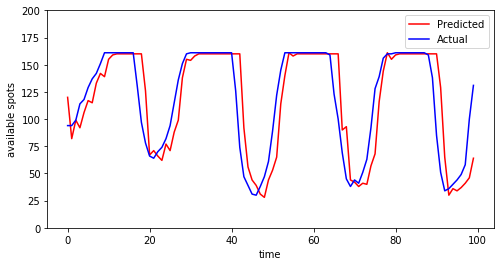

In [173]:
utf.plot_graph(Z, Y_test)

In [171]:
utf.calculate_accuracy(Z,Y_test)

{'name': 'No Name',
 'r2': 0.69902204424373671,
 'rms': 25.673916724956477,
 'tol': 0.57}